In [1]:
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, precision_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import display, Markdown, Latex

## matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Linear Discriminant Analysis

We are interested in classifying an observation into one of $K$ classes, with $K\geq 2$. In other words, the qualitative response variable $Y$ can take $K$ possible distinct and unordered values. The probability that a given observation is associated with the $k$th category of the response variable $Y$ and the density function of X for an observation that comes from the kth class are represented by $pi_k$ and $f_k (x) = Pr(X = x|Y = k)$, respectively.


As can be seen, $f_k (x)$ can be a large value if there is a high probability that an observation in the $k$th class has $X \approx x$, and $f_k (x)$ takes smaller values if it is very unlikely that an observation in the $k$th class has $X \approx x$. It follows from *Bayes’ theorem* that

$$Pr(Y = k|X = x) =\dfrac{\pi_k f_k (x)}{\sum_{j=1}^{K}\pi_j f_j (x)}$$

<div class="alert alert-block alert-info">
<font size="+2"><b>Default Dataset Example</b></font>
</div>

In this article, we demonstrate the concept of classification using the simulated Default dataset. This dataset can be extracted from the [**ISLR package**](https://cran.r-project.org/web/packages/ISLR/index.html) using the following syntax.

```R
library (ISLR)
write.csv(Default, "Default.csv")
```

We would like to predict whether an individual will default on his or her credit card payment, based on annual income and monthly credit card balance.

In [2]:
Default = pd.read_csv('Data/Default.csv', index_col = 0)
Default.columns = [x.title() for x in Default.columns]
Default.head(5)

,Default,Student,Balance,Income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


Here, Student status is encoded as a dummy variable as

$$\text{Student}=\begin{cases}
  1, & \mbox{Student},\\
  0, & \mbox{Non-Student}. \\
\end{cases}$$
This means

In [3]:
df = Default.copy()
df['Default'] = df.Default.factorize()[0]
df['Student'] = df.Student.factorize()[0]
df.head()

,Default,Student,Balance,Income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


Preparing Data:

In [4]:
# X
X = df[['Balance', 'Income', 'Student']].values
# True Default
y = df.Default.values

We can do a Linear Discriminant Analysis using [**sklearn Linear Discriminant Analysis**](https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html#sklearn.lda.LDA):

In [5]:
LDA = LinearDiscriminantAnalysis(solver='svd')
# Predicted Default
y_pred = LDA.fit(X, y).predict(X)

# Dataframe
df_LDA = pd.DataFrame({'True Default Status': y, 'Predicted Default Status': y_pred})
# replacing the dummy variables with 'Yes' and 'No'
df_LDA.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

# grouping by each category and creating a new Table
Table=df_LDA.groupby(['Predicted Default Status','True Default Status']).size().unstack('True Default Status')
Table

True Default Status,No,Yes
Predicted Default Status,,
No,9645,254
Yes,22,79


The above table is known as **confusion matrix**. This table here compares the LDA predictions to the true default statuses for the 10,000 training observations in the Default data set.

Elements on the diagonal of the matrix, 2645 and 79, represent individuals whose default statuses were correctly predicted, and off-diagonal elements represent individuals that were misclassified. LDA made incorrect predictions for 22 individuals who did not default and for 254 individuals who did default.

In [6]:
Table['Total']=[sum(Table.iloc[0]), sum(Table.iloc[1])]
temp=pd.DataFrame({'No': [sum(Table.iloc[:,0])], 'Yes': [sum(Table.iloc[:,1])], 'Total': [sum(Table.iloc[:,2])]})
Table = pd.concat([Table, temp])
del temp
Table.rename(index={0:'Total'}, inplace=True)
Table

True Default Status,No,Yes,Total
No,9645,254,9899
Yes,22,79,101
Total,9667,333,10000


To identify high-risk individuals, an error rate of

In [7]:
print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Error Rate'  + Style.RESET_ALL + ' = %.2f Percent'
      % (Table.iloc[0,1]/Table.iloc[-1,1]*100))

Error Rate = 76.28 Percent


percent of individuals who default may well be unacceptable.

In [8]:
Results = pd.DataFrame(classification_report(y, y_pred, target_names=['No', 'Yes'], output_dict=True)).T
display(Results.round(2))

,precision,recall,f1-score,support
No,0.97,1.00,0.99,9667.00
Yes,0.78,0.24,0.36,333.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.88,0.62,0.67,10000.00
weighted avg,0.97,0.97,0.97,10000.00


The **sensitivity**:

In [9]:
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'The percentage of non-defaulters that are identified'
      + Style.RESET_ALL + ' = %.2f Percent' % (100*Results.loc[(Results.index == 'accuracy'), 'recall'].values[0]))

The percentage of non-defaulters that are identified = 97.24 Percent


The **specificity**:

In [10]:
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'The percentage of true defaulters that are identified'
      + Style.RESET_ALL + ' = %.2f Percent' % (100*Results.loc[(Results.index == 'Yes'), 'recall'].values[0]))

The percentage of true defaulters that are identified = 23.72 Percent


The Bayes classifier works by assigning an observation to the class for which the posterior probability $p_k (X)$ is greatest. In the two-class case, this amounts to assigning an observation to the default class if

$$\mbox{Pr (Default = Yes | X = x) }> 0.5. $$

However, if we are concerned about incorrectly predicting the default status for individuals who default, then we can consider
lowering this threshold.

$$\mbox{Pr (Default = Yes | X = x) > Decision probability} $$

For example, we can consider

$$\mbox{Pr (Default = Yes | X = x) > }0.2. $$

In [11]:
Decision_probability = 0.2
y_pred = LDA.fit(X, y).predict_proba(X)

df_LDA= pd.DataFrame({'True Default Status': y,
                      'Predicted Default Status': y_pred[:,1] > Decision_probability})
df_LDA.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)
Table=df_LDA.groupby(['Predicted Default Status','True Default Status']).size().unstack('True Default Status')
Table

True Default Status,No,Yes
Predicted Default Status,,
No,9435,140
Yes,232,193


In [12]:
Table['Total']=[sum(Table.iloc[0]), sum(Table.iloc[1])]
temp=pd.DataFrame({'No': [sum(Table.iloc[:,0])], 'Yes': [sum(Table.iloc[:,1])], 'Total': [sum(Table.iloc[:,2])]})
Table = pd.concat([Table, temp])
del temp
Table.rename(index={0:'Total'}, inplace=True)
Table

True Default Status,No,Yes,Total
No,9435,140,9575
Yes,232,193,425
Total,9667,333,10000


In [13]:
Results = pd.DataFrame(classification_report(y, y_pred [:,1] > Decision_probability,
                                             target_names=['No', 'Yes'], output_dict=True)).T
display(Results.round(2))

,precision,recall,f1-score,support
No,0.99,0.98,0.98,9667.00
Yes,0.45,0.58,0.51,333.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.72,0.78,0.74,10000.00
weighted avg,0.97,0.96,0.96,10000.00


Now LDA predicts that 425 individuals will default. Of the 333 individuals
who default, LDA correctly predicts all but 140, or

In [14]:
print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Error Rate'  + Style.RESET_ALL + ' = %.2f Percent'
      % (Table.iloc[0,1]/Table.iloc[-1,1]*100))

Error Rate = 42.04 Percent


This is a vast improvement over the error rate of $76\%$ that resulted from using the threshold of 50%. However, this improvement comes at a cost: now 232 individuals who do not default are incorrectly classified. 

***

<div class="alert alert-block alert-info">
<font size="+2"><b>The Stock Market Data</b></font>
</div>

The Smarket data is part of the the [**ISLR package**](https://cran.r-project.org/web/packages/ISLR/index.html). This dataset consists of percentage returns for the S&P 500 stock index over 1, 250 days, from the beginning of 2001 until the end of 2005. This dataset can be extracted from the [**ISLR package**](https://cran.r-project.org/web/packages/ISLR/index.html) using the following syntax.


```R
library (ISLR)
write.csv(Smarket, "Smarket.csv")
```

In [15]:
Smarket = pd.read_csv('Data/Smarket.csv', index_col=0)
# Smarket['Year'] = pd.to_datetime(Smarket['Year'], format='%Y')
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


Let's divide this dataset into train and test sets. In doing so, the data before 2005 is considered for the train set and the data from 2005 onward for the test set. That is

In [16]:
X_train, y_train = Smarket.loc[(Smarket['Year'] < 2005), ['Lag1','Lag2']], Smarket.loc[(Smarket['Year'] < 2005), ['Direction']]
X_test, y_test = Smarket.loc[(Smarket['Year'] >= 2005), ['Lag1','Lag2']], Smarket.loc[(Smarket['Year'] >= 2005), ['Direction']]

pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set,X_train,X_test,y_train,y_test
Shape,"(998, 2)","(252, 2)","(998, 1)","(252, 1)"


In [17]:
LDA = LinearDiscriminantAnalysis(solver='svd')
# Predictions
_ = LDA.fit(X_train, y_train)
y_pred = LDA.predict(X_test)

* **Prior probabilities of groups:**

In [18]:
Class_Names = list(np.sort(Smarket.Direction.unique()))
PriorProbabilities = pd.DataFrame(LDA.priors_, columns = {'Prior probabilities of groups'}, index = Class_Names)
display(PriorProbabilities.T.round(3))
print('%.2f percent of the training observations correspond to days during which the market went down.' %
        (100*PriorProbabilities.loc['Down'].values[0]))

,Down,Up
Prior probabilities of groups,0.492,0.508


49.20 percent of the training observations correspond to days during which the market went down.


* **Group means:**

These are the average of each predictor within each class, and are used by LDA as estimates of $\mu_k$.

In [19]:
GroupMeans = pd.DataFrame(LDA.means_, columns =X_train.columns, index = Class_Names)
display(GroupMeans.round(4))

,Lag1,Lag2
Down,0.0428,0.0339
Up,-0.0395,-0.0313


* **Coefficients of linear discriminants:**

In [20]:
display(Latex(r'$\pi_{1}$ = %.4f and $\pi_{2}$ = %.4f' % (LDA.coef_[0,0], LDA.coef_[0,1])))

<IPython.core.display.Latex object>

If $\pi_1~\textbf{Lag1}~+~\pi_2~\textbf{Lag2}$ is large, then the LDA classifier will predict a market increase, and if it is small, then the LDA classifier will predict a market decline.

* **Classification Report:**

In [21]:
Results = pd.DataFrame(classification_report(y_test, y_pred,
                                             target_names=Class_Names, output_dict=True)).T
display(Results.round(2))

,precision,recall,f1-score,support
Down,0.50,0.32,0.39,111.00
Up,0.58,0.75,0.66,141.00
accuracy,0.56,0.56,0.56,0.56
macro avg,0.54,0.53,0.52,252.00
weighted avg,0.55,0.56,0.54,252.00


Applying a 50 % threshold to the posterior probabilities allows us to recreate the predictions contained in lda.pred$class.

In [22]:
pred_proba = LDA.predict_proba(X_test)
np.unique(pred_proba[:,1]>0.5, return_counts=True)

(array([False,  True]), array([ 70, 182], dtype=int64))

If we wanted to use a posterior probability threshold other than 50% in
order to make predictions, then we could easily do so. For instance, suppose
that we wish to predict a market decrease only if we are very certain that the
market will indeed decrease on that day—say, if the posterior probability
is at least 90 %.

In [23]:
np.unique(pred_proba[:,1]>0.9, return_counts=True)

(array([False]), array([252], dtype=int64))

No days in 2005 meet that threshold!

In [24]:
print(' In fact, the greatest posterior probability of decrease in all of 2005 was %.2f percent.' % (100*pred_proba[:,0].max()))

 In fact, the greatest posterior probability of decrease in all of 2005 was 52.02 percent.


* **Confusion Matrix**:

Confusion Matrix


,Down,Up
Down,35,76
Up,35,106


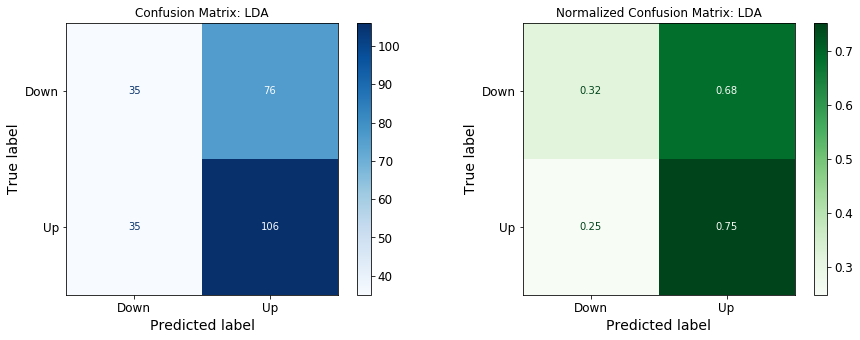

In [25]:
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'Confusion Matrix'  + Style.RESET_ALL)
display(pd.DataFrame(data = confusion_matrix(y_test, y_pred), index = Class_Names, columns = Class_Names))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

_ = plot_confusion_matrix(LDA, X_test, y_test, display_labels= Class_Names, cmap= "Blues", normalize= None, ax = ax[0])
_ = ax[0].set_title('Confusion Matrix: LDA')

_ = plot_confusion_matrix(LDA, X_test, y_test, display_labels= Class_Names, cmap= "Greens", normalize= 'true', ax = ax[1])
_ = ax[1].set_title('Normalized Confusion Matrix: LDA')

***

## Refrences

* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). [An introduction to statistical learning](https://link.springer.com/book/10.1007/978-1-4614-7138-7) (Vol. 112, pp. 3-7). New York: springer.

* Jordi Warmenhoven, [ISLR-python](https://github.com/JWarmenhoven/ISLR-python)
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2017). [ISLR: Data for an Introduction to Statistical Learning with Applications in R](https://cran.r-project.org/web/packages/ISLR/index.html)

***